<!-- Notebook title -->
# Object Detection - MaskRCNN

# 1. Notebook Description

### 1.1 Task Description
<!-- 
- A brief description of the problem you're solving with machine learning.
- Define the objective (e.g., classification, regression, clustering, etc.).
-->

#### Object Detection

In this task you are suppose to implement a more advanced convolutional net using the Balloon dataset. The new network should contain one or more of the following

**Data Preparation**:

- Download the balloons dataset from https://github.com/matterport/Mask_RCNN/releases.

- Perform necessary pre-processing steps such as resizing, normalization, and data augmentation to prepare the dataset for training.

- Split the dataset into training, validation, and test sets for model evaluation.

**Implement Object Detection Using a Pre-Trained Model**:

- Use a pre-trained model such as MaskRCNN to perform instance segmentation on the dataset.

- Start by understanding and adapting the architecture of MaskRCNN or another instance segmentation model.

- Train and fine-tune the model using appropriate hyperparameters, such as learning rate, batch size, and number of epochs, to adjust it to the new dataset.


*Hints*:

- You can follow the tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

- You can look at Tensorflow example https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238

- Choose the network architecture with care.

- Train and validate all algorithms.

- Make the necessary assumptions.


### 1.2 Useful Resources
<!--
- Links to relevant papers, articles, or documentation.
- Description of the datasets (if external).
-->

### 1.2.1 Data

#### 1.2.1.1 Common

* [Datasets Kaggle](https://www.kaggle.com/datasets)  
  &nbsp;&nbsp;&nbsp;&nbsp;A vast repository of datasets across various domains provided by Kaggle, a platform for data science competitions.
  
* [Toy datasets from Sklearn](https://scikit-learn.org/stable/datasets/toy_dataset.html)  
  &nbsp;&nbsp;&nbsp;&nbsp;A collection of small datasets that come with the Scikit-learn library, useful for quick prototyping and testing algorithms.
  
* [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)  
  &nbsp;&nbsp;&nbsp;&nbsp;A widely-used repository for machine learning datasets, with a variety of real-world datasets available for research and experimentation.
  
* [Google Dataset Search](https://datasetsearch.research.google.com/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A tool from Google that helps to find datasets stored across the web, with a focus on publicly available data.
  
* [AWS Public Datasets](https://registry.opendata.aws/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A registry of publicly available datasets that can be analyzed on the cloud using Amazon Web Services (AWS).
  
* [Microsoft Azure Open Datasets](https://azure.microsoft.com/en-us/services/open-datasets/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A collection of curated datasets from various domains, made available by Microsoft Azure for use in machine learning and analytics.
  
* [Awesome Public Datasets](https://github.com/awesomedata/awesome-public-datasets)  
  &nbsp;&nbsp;&nbsp;&nbsp;A GitHub repository that lists a wide variety of datasets across different domains, curated by the community.
  
* [Data.gov](https://www.data.gov/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A portal to the US government's open data, offering access to a wide range of datasets from various federal agencies.
  
* [Google BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data)  
  &nbsp;&nbsp;&nbsp;&nbsp;Public datasets hosted by Google BigQuery, allowing for quick and powerful querying of large datasets in the cloud.
  
* [Papers with Code](https://paperswithcode.com/datasets)  
  &nbsp;&nbsp;&nbsp;&nbsp;A platform that links research papers with the corresponding code and datasets, helping researchers reproduce results and explore new data.
  
* [Zenodo](https://zenodo.org/)  
  &nbsp;&nbsp;&nbsp;&nbsp;An open-access repository that allows researchers to share datasets, software, and other research outputs, often linked to academic publications.
  
* [The World Bank Open Data](https://data.worldbank.org/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A comprehensive source of global development data, with datasets covering various economic and social indicators.
  
* [OpenML](https://www.openml.org/)  
  &nbsp;&nbsp;&nbsp;&nbsp;An online platform for sharing datasets, machine learning experiments, and results, fostering collaboration in the ML community.
  
* [Stanford Large Network Dataset Collection (SNAP)](https://snap.stanford.edu/data/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A collection of large-scale network datasets from Stanford University, useful for network analysis and graph-based machine learning.
  
* [KDnuggets Datasets](https://www.kdnuggets.com/datasets/index.html)  
  &nbsp;&nbsp;&nbsp;&nbsp;A curated list of datasets for data mining and data science, compiled by the KDnuggets community.


#### 1.2.1.2 Project

### 1.2.2 Learning

* [K-Nearest Neighbors on Kaggle](https://www.kaggle.com/code/mmdatainfo/k-nearest-neighbors)

* [Complete Guide to K-Nearest-Neighbors](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor)

### 1.2.3 Documentation

---

# 2. Setup

## 2.1 Imports
<!--
- Import necessary libraries (e.g., `numpy`, `pandas`, `matplotlib`, `scikit-learn`, etc.).
-->

In [1]:
import os
import json
import random
import subprocess
import time

import numpy as np
import cv2
from PIL import Image
import skimage


import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
from torch.optim import Adam, SGD

import optuna

import torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torchvision.models.detection import FasterRCNN, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

import matplotlib.pyplot as plt

from ikt450.src.common_imports import *
from ikt450.src.config import get_paths
from ikt450.src.common_func import load_dataset, save_dataframe, ensure_dir_exists

## 2.2 Global Variables
<!--
- Define global constants, paths, and configuration settings used throughout the notebook.
-->

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [3]:
paths = get_paths()

PATH_ASSIGNMENT_DIR = paths['PATH_OBJECT_DETECTION']

train_json_file = f"{paths['PATH_COMMON_DATASETS']}/balloon_dataset/balloon/train/via_region_data.json"
train_img_dir = f"{paths['PATH_COMMON_DATASETS']}/balloon_dataset/balloon/train"
test_json_file = f"{paths['PATH_COMMON_DATASETS']}/balloon_dataset/balloon/val/via_region_data.json"
test_img_dir = f"{paths['PATH_COMMON_DATASETS']}/balloon_dataset/balloon/val"

In [4]:
writer = SummaryWriter()

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [6]:
# Model
hidden_layer = 512
resize_to = 512
num_epochs = 50

# Data augmentation
flip_prob = 0.5
brightness = 0.1
contrast = 0.1
saturation = 0.1
hue = 0.1

# Training
batch_size = 4
num_workers = 0
num_classes = 2     # 1 class (balloon) + background
lr=1e-5
weight_decay=1e-5

# Prediction
pred_threshold=0.85

In [7]:
# Tuner settings
lr_min = 1e-5
lr_max = 1e-3
weight_decay_min = 1e-5
weight_decay_max = 1e-3

optimizers = ["Adam", "SGD"]
epochs_min = 5
epochs_max = 100

direction = "minimize"
study_name = "mask_rcnn_hyperparameter_tuning"
storage = f"sqlite:///{PATH_ASSIGNMENT_DIR}/results/mask_rcnn_hyperparameter_tuning.db"
n_trials = 10
optuna_port = "8080"

## 2.3 Classes

In [8]:
class BalloonsDataset(Dataset):
    def __init__(self, json_file, img_dir, transforms=None):
        with open(json_file) as f:
            self.data = json.load(f)
        
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_ids = list(self.data.keys()) 

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Filename
        img_id = self.image_ids[idx]
        img_info = self.data[img_id]
        img_filename = img_info['filename']
        
        # Load
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")
        
        # Regions (objects in the image)
        regions = img_info['regions']
        
        # Initialize lists for bounding boxes, masks, and labels
        boxes = []
        masks = []
        labels = []
        
        # Process each region (each object)
        for region in regions.values():
            shape_attributes = region['shape_attributes']
            all_points_x = shape_attributes['all_points_x']
            all_points_y = shape_attributes['all_points_y']
            
            # Polygon mask for the balloon
            mask = np.zeros((img.height, img.width), dtype=np.uint8)
            points = np.array([list(zip(all_points_x, all_points_y))], dtype=np.int32)
            cv2.fillPoly(mask, points, 1)  # Fill the polygon with 1s in the mask
            
            # Convert polygon to bounding box [x_min, y_min, x_max, y_max]
            x_min = min(all_points_x)
            y_min = min(all_points_y)
            x_max = max(all_points_x)
            y_max = max(all_points_y)
            
            # Add the bounding box, mask, and label (1 for balloon)
            boxes.append([x_min, y_min, x_max, y_max])
            masks.append(mask)
            labels.append(1)  # Only one class: balloon

        # Convert everything to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Compute the area of the bounding boxes
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # Assume all instances are not crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        # Add image_id
        image_id = torch.tensor([idx])
        
        # Convert masks to PIL images for transformations
        masks = [Image.fromarray(mask) for mask in masks]
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': areas,
            'iscrowd': iscrowd
        }
        
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

In [9]:
class ToTensor(object):
    def __call__(self, img, target):
        img = TF.to_tensor(img)
        if 'masks' in target:
            # Convert each mask to a tensor and stack them
            masks = [torch.as_tensor(np.array(mask), dtype=torch.uint8) for mask in target['masks']]
            target['masks'] = torch.stack(masks, dim=0)
        return img, target

In [10]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

In [11]:
class RandomHorizontalFlip(object):
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, img, target):
        if random.random() < self.flip_prob:
            img = TF.hflip(img)
            width = img.width

            # Flip bounding boxes
            if 'boxes' in target:
                boxes = target['boxes']
                boxes = boxes.clone()
                boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
                target['boxes'] = boxes

            # Flip masks
            if 'masks' in target:
                target['masks'] = [TF.hflip(mask) for mask in target['masks']]

        return img, target

In [12]:
class Resize(object):
    def __init__(self, size):
        self.size = size  # (height, width)

    def __call__(self, img, target):
        # Original size
        orig_width, orig_height = img.size  # (width, height)
        new_height, new_width = self.size  # (height, width)
        img = TF.resize(img, (new_height, new_width))

        # Scale factors
        scale_x = new_width / orig_width
        scale_y = new_height / orig_height

        # Resize bounding boxes
        if 'boxes' in target:
            boxes = target['boxes']
            boxes = boxes.clone()
            boxes[:, 0] = boxes[:, 0] * scale_x
            boxes[:, 2] = boxes[:, 2] * scale_x
            boxes[:, 1] = boxes[:, 1] * scale_y
            boxes[:, 3] = boxes[:, 3] * scale_y
            target['boxes'] = boxes

        # Resize masks
        if 'masks' in target:
            target['masks'] = [TF.resize(mask, (new_height, new_width), interpolation=Image.NEAREST) for mask in target['masks']]
            
        return img, target

In [13]:
class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.transform = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, img, target):
        img = self.transform(img)
        return img, target

In [14]:
class Normalize(object):
    def __call__(self, img, target):
        img = TF.normalize(img, mean=mean, std=std)
        return img, target

## 2.4 Functions

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
def get_balloons_loader(json_file, img_dir, batch_size=4, shuffle=True, num_workers=4, transforms=None):
    # Apply default transformation if none is provided
    if transforms is None:
        transforms = transforms.ToTensor()  # Default transformation to convert PIL images to tensors
    
    dataset = BalloonsDataset(json_file=json_file, img_dir=img_dir, transforms=transforms)
    
    # Create the DataLoader
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn  # Use the defined collate_fn instead of a lambda
    )
    
    return data_loader

In [17]:
def get_balloons_loader_train(json_file, img_dir, batch_size=4, shuffle=True, num_workers=4, transforms=None):
    # Apply default transformation if none is provided
    if transforms is None:
        transforms = transforms.ToTensor()  # Default transformation to convert PIL images to tensors

    dataset = BalloonsDataset(json_file=json_file, img_dir=img_dir, transforms=transforms)
    # split the dataset into train and test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


    # Create the DataLoader
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn  # Use the defined collate_fn instead of a lambda
    )

     # Create the DataLoader
    test_data_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn  # Use the defined collate_fn instead of a lambda
    )
    return test_data_loader, train_data_loader

In [18]:
def get_model_instance_segmentation(num_classes, hidden_layer=256):
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT  # Use COCO-trained weights
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)

    # Number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # Replace the pre-trained head with a new one (for custom classes)

    # Number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = hidden_layer
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes) # Replace the mask predictor with a new one (for custom classes)

    return model

In [19]:
def denormalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image_tensor.clone()
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization
    return image

In [20]:
def visualize_image_with_masks_side_by_side(image_tensor, pred_masks, pred_boxes, pred_scores, gt_masks, gt_boxes, threshold=0.0):

    image = denormalize(image_tensor).cpu().detach()

    # Convert from (C, H, W) to (H, W, C)
    if image.shape[0] == 3:
        image = image.permute(1, 2, 0)

    image = torch.clamp(image, 0, 1).numpy()

    # Subplots for side-by-side comparison
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    # Predicted Labels
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title('Predicted Labels')

    # Plot predicted masks and bounding boxes
    for i in range(pred_masks.shape[0]):
        if pred_scores[i] >= threshold:
            mask = pred_masks[i, 0].cpu().detach().numpy()
            mask = np.ma.masked_where(mask == 0, mask)
            axs[0].imshow(mask, cmap='cool', alpha=0.5)

            box = pred_boxes[i].cpu().detach().numpy()
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
            axs[0].add_patch(rect)

    # Ground Truth Labels
    axs[1].imshow(image)
    axs[1].axis('off')
    axs[1].set_title('Ground Truth Labels')

    for i in range(gt_masks.shape[0]):
        mask = gt_masks[i].cpu().detach().numpy()
        mask = np.ma.masked_where(mask == 0, mask)
        axs[1].imshow(mask, cmap='cool', alpha=0.5)

        box = gt_boxes[i].cpu().detach().numpy()
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='green', linewidth=2)
        axs[1].add_patch(rect)

    plt.tight_layout()
    plt.show()
    

In [21]:
def objective(trial, train_data_loader, val_data_loader, device, config, writer):
    
    lr = trial.suggest_float("lr", config['lr_min'], config['lr_max'])
    weight_decay = trial.suggest_float("weight_decay", config['weight_decay_min'], config['weight_decay_max'])
    optimizer_name = trial.suggest_categorical("optimizer", config['optimizers'])
    num_epochs = trial.suggest_int("num_epochs", config['epochs_min'], config['epochs_max'])

    # Model
    model = get_model_instance_segmentation(config['num_classes'])
    model.to(device)

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)

    # Training and validation loop
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, targets in train_data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()
            losses.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation loop
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_data_loader:
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()
        
        # Best validation loss
        avg_val_loss = val_loss / len(val_data_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        
        trial.report(best_val_loss, epoch)

        writer.add_scalars("Loss - tuning", {f"train {trial.number}": train_loss / len(train_data_loader), f"val {trial.number}": avg_val_loss}, epoch)
        writer.flush()
    
    

    return best_val_loss

---

# 4. Data Processing

In [22]:
# Define transforms
train_transform = Compose([
    Resize((resize_to, resize_to)),
    RandomHorizontalFlip(flip_prob=flip_prob),
    #RandomVerticalFlip(flip_prob=0.5),
    #RandomRotation(degrees=15),
    ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
    ToTensor(),
    Normalize(),
])

test_transform = Compose([
    Resize((resize_to, resize_to)),
    ToTensor(),
    Normalize(),
])

In [23]:
with open(train_json_file) as f:
    data = json.load(f)

In [24]:
# get the image names and the corresponding list of coordinates from all_points_x and all_points_y for each region in the json file
image_names = list(data.keys())
image_names
coordinates = []
for image_name in image_names:
    regions = data[image_name]['regions']
    for region_index in regions:
        coordinates.append((image_name, regions[region_index]['shape_attributes']['all_points_x'], regions[region_index]['shape_attributes']['all_points_y']))

In [25]:
train_data_loader, test_data_loader = get_balloons_loader_train(train_json_file, train_img_dir, batch_size=batch_size, num_workers=num_workers, transforms=train_transform)
val_data_loader = get_balloons_loader(test_json_file, test_img_dir, batch_size=batch_size, num_workers=num_workers, transforms=test_transform)

## 4.2 Data inspection
<!--
- Preview the data (e.g., `head`, `describe`).
-->

In [26]:
# TODO

# 5. Model Development

In [27]:
model = get_model_instance_segmentation(num_classes, hidden_layer=hidden_layer)
print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## 5.1 Model Selection
<!--
- Choose the model(s) to be trained (e.g., linear regression, decision trees, neural networks).
-->

In [28]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

## 5.2 Model Training
<!--
- Train the selected model(s) using the training data.
-->

In [29]:
tb_process = subprocess.Popen(
    ["tensorboard", "--logdir=runs", "--port=6006"],
    stdout=subprocess.DEVNULL,  # Suppress standard output
    stderr=subprocess.DEVNULL   # Suppress standard error
)
time.sleep(5)

print("TensorBoard is running. Access it via http://localhost:6006/")

TensorBoard is running. Access it via http://localhost:6006/


In [30]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    sum_loss = 0.0

    for images, targets in train_data_loader:
        images = [image.to(device) for image in images]                         # Move images to device (GPU/CPU)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]    # Move targets to device

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values()) # Total loss
        sum_loss += losses.item()

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = sum_loss / len(train_data_loader)

    # evaluate the model
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_data_loader:
            images = [image.to(device) for image in images]  # Move images to device (GPU/CPU)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()



    avg_val_loss = val_loss / len(val_data_loader)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")

    writer.add_scalars('Loss - first run', {'train': avg_train_loss, 'val': avg_val_loss}, epoch)
    writer.flush()

Epoch 1, Val Loss: 13.1895
Epoch 2, Val Loss: 8.3351
Epoch 3, Val Loss: 6.9401
Epoch 4, Val Loss: 5.3789
Epoch 5, Val Loss: 5.2305
Epoch 6, Val Loss: 4.8917
Epoch 7, Val Loss: 5.4663
Epoch 8, Val Loss: 4.6650
Epoch 9, Val Loss: 4.6533
Epoch 10, Val Loss: 4.9740
Epoch 11, Val Loss: 4.8893
Epoch 12, Val Loss: 4.5763
Epoch 13, Val Loss: 4.0273
Epoch 14, Val Loss: 4.7097
Epoch 15, Val Loss: 4.1539
Epoch 16, Val Loss: 3.9161
Epoch 17, Val Loss: 4.3803
Epoch 18, Val Loss: 3.6811
Epoch 19, Val Loss: 3.9683
Epoch 20, Val Loss: 3.7674
Epoch 21, Val Loss: 4.1653
Epoch 22, Val Loss: 4.2559
Epoch 23, Val Loss: 4.2042
Epoch 24, Val Loss: 3.3363
Epoch 25, Val Loss: 3.2546
Epoch 26, Val Loss: 3.4263
Epoch 27, Val Loss: 3.8855
Epoch 28, Val Loss: 3.0474
Epoch 29, Val Loss: 3.1671
Epoch 30, Val Loss: 3.7682
Epoch 31, Val Loss: 3.6651
Epoch 32, Val Loss: 3.6128
Epoch 33, Val Loss: 2.8278
Epoch 34, Val Loss: 3.0500
Epoch 35, Val Loss: 3.1645
Epoch 36, Val Loss: 3.6414
Epoch 37, Val Loss: 3.2331
Epoch 38,

## 5.3 Model Evaluation
<!--
- Evaluate model performance on validation data.
- Use appropriate metrics (e.g., accuracy, precision, recall, RMSE).
-->

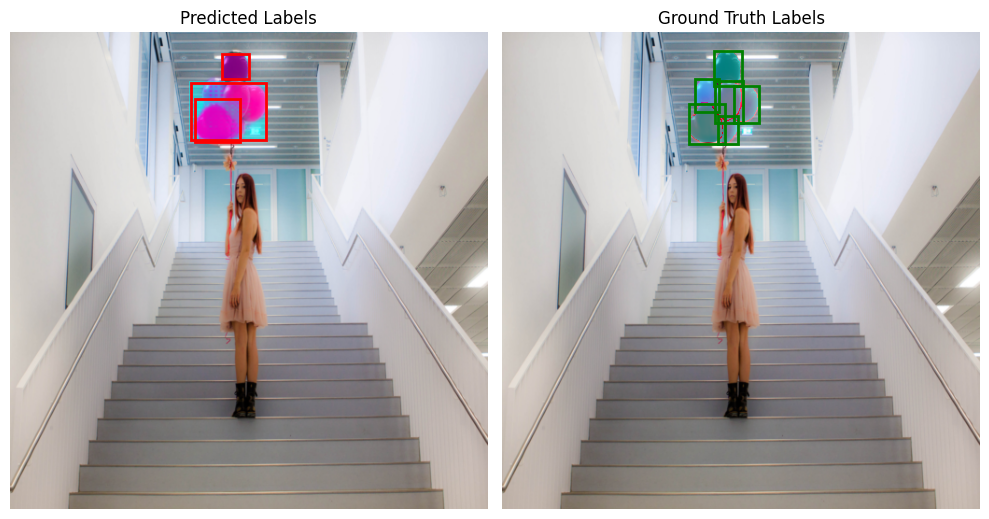

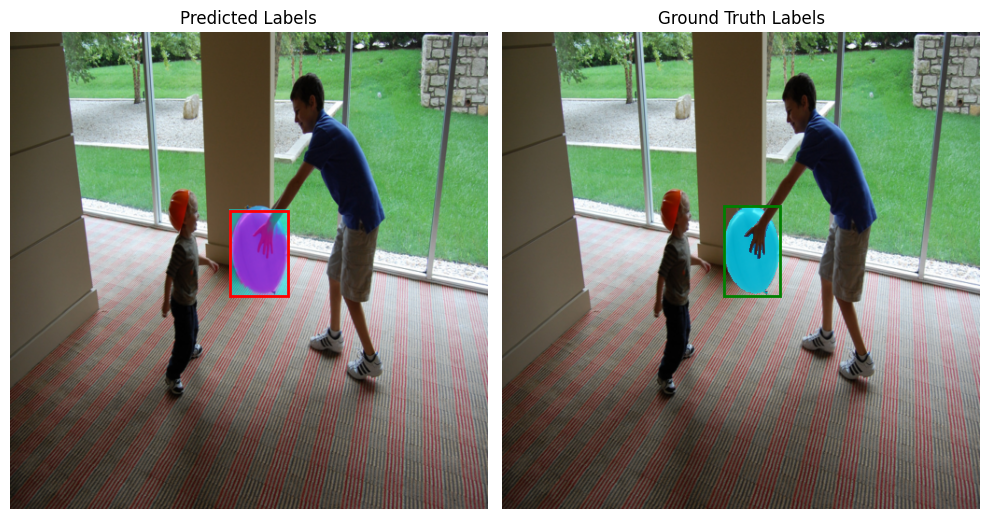

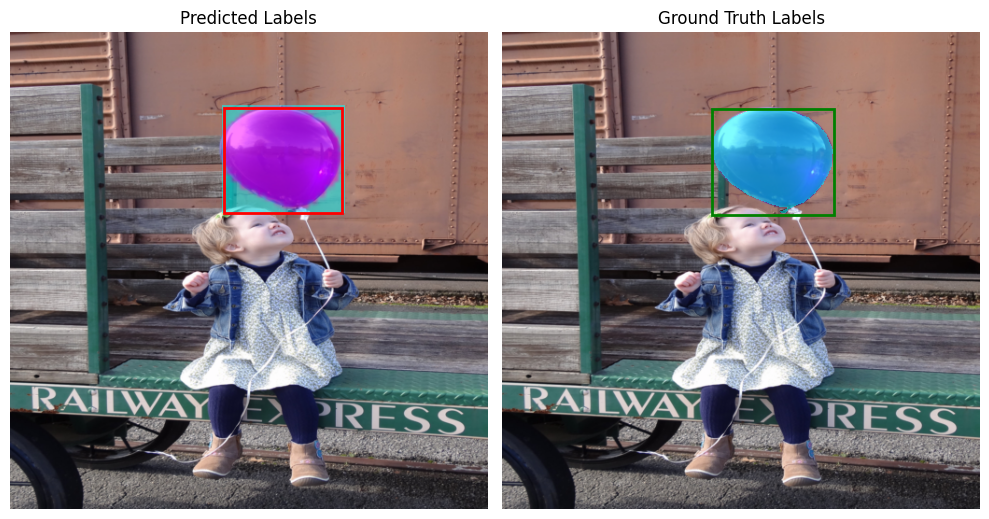

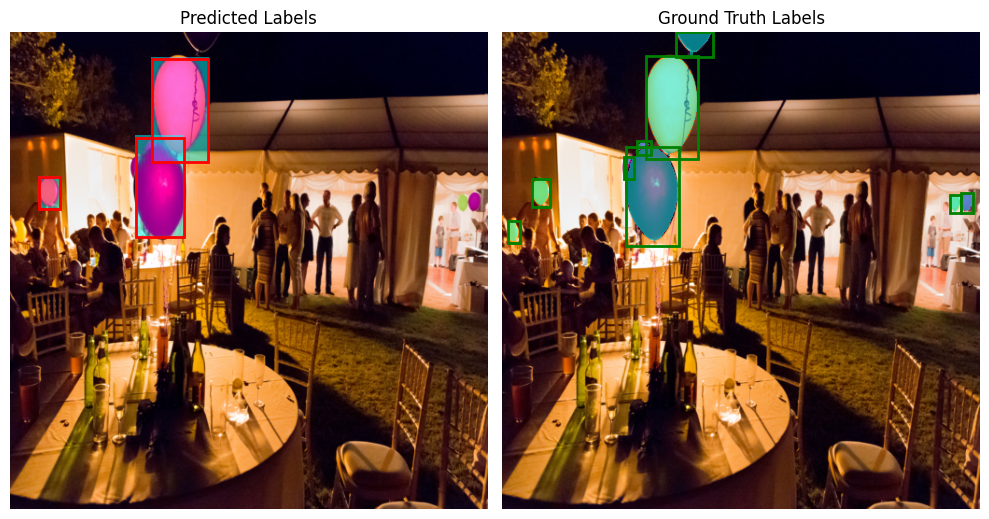

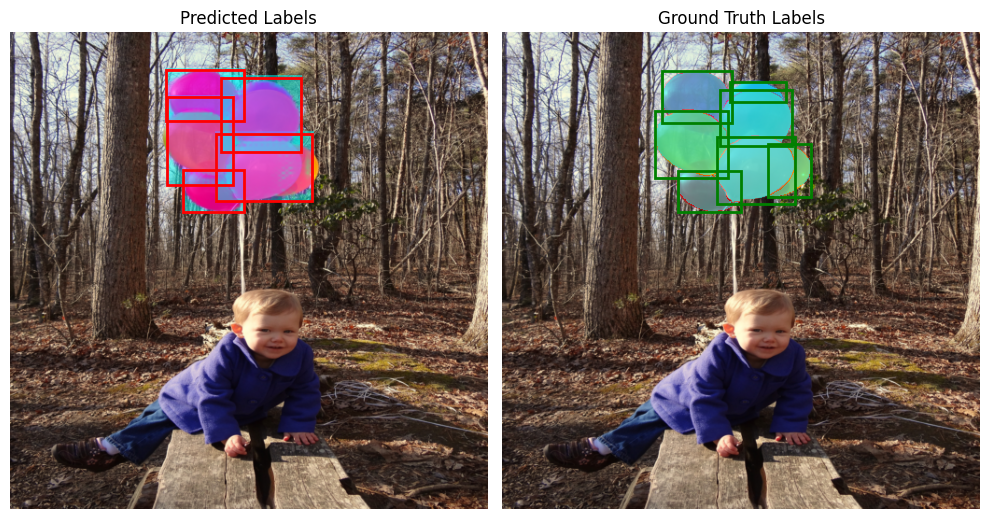

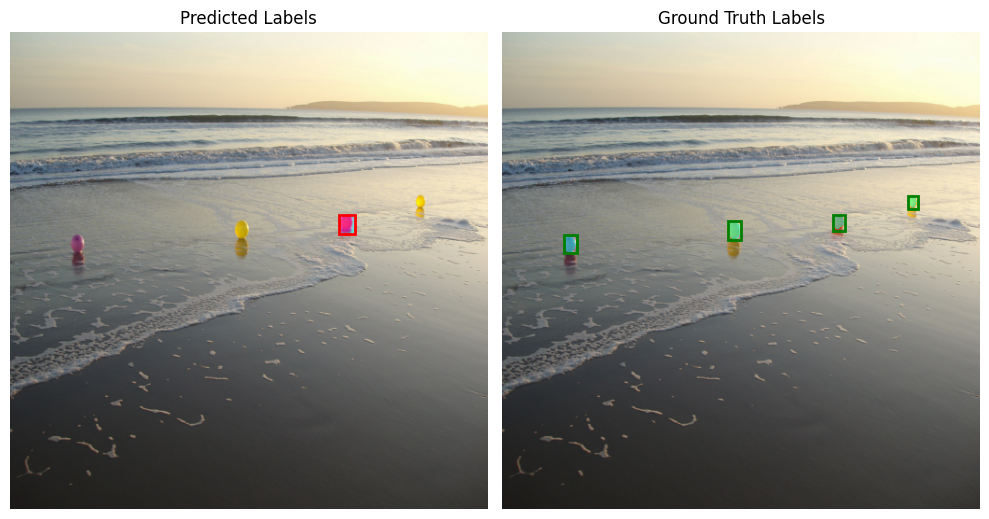

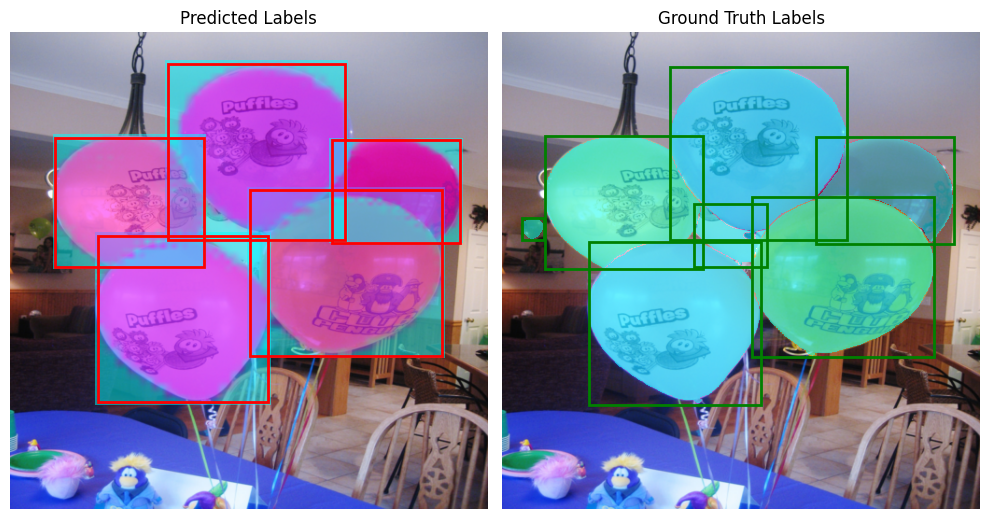

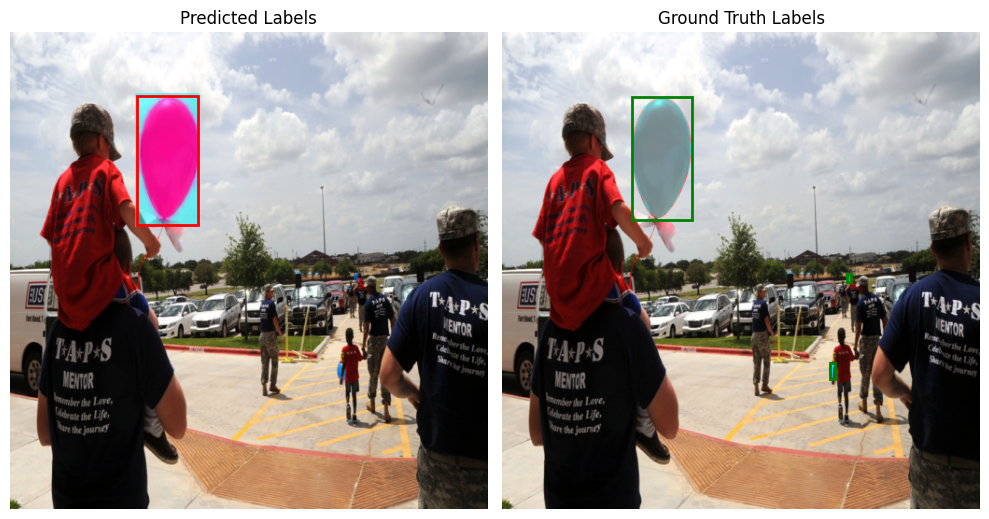

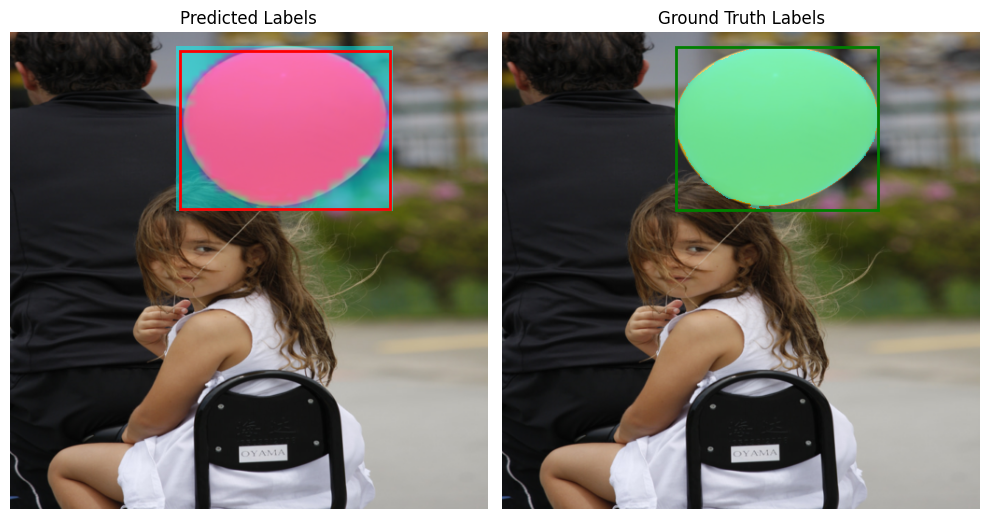

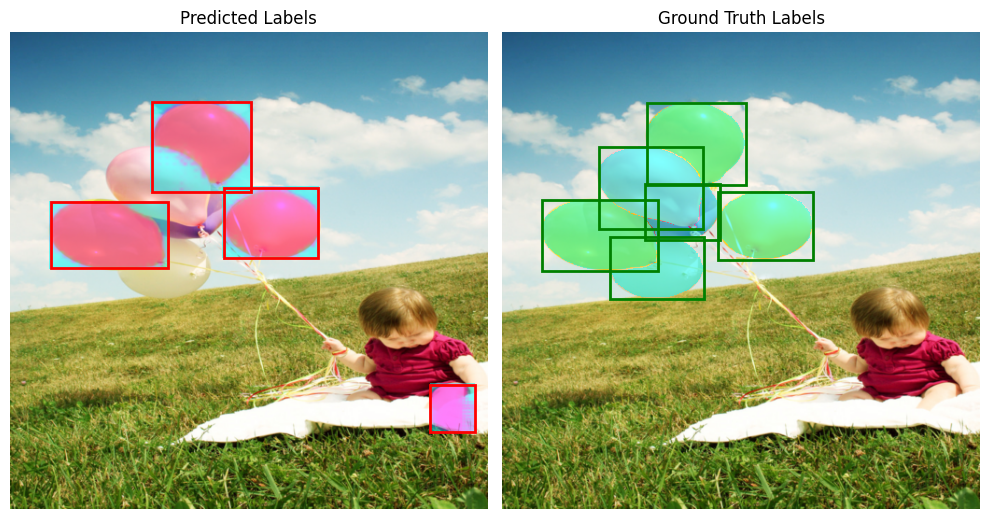

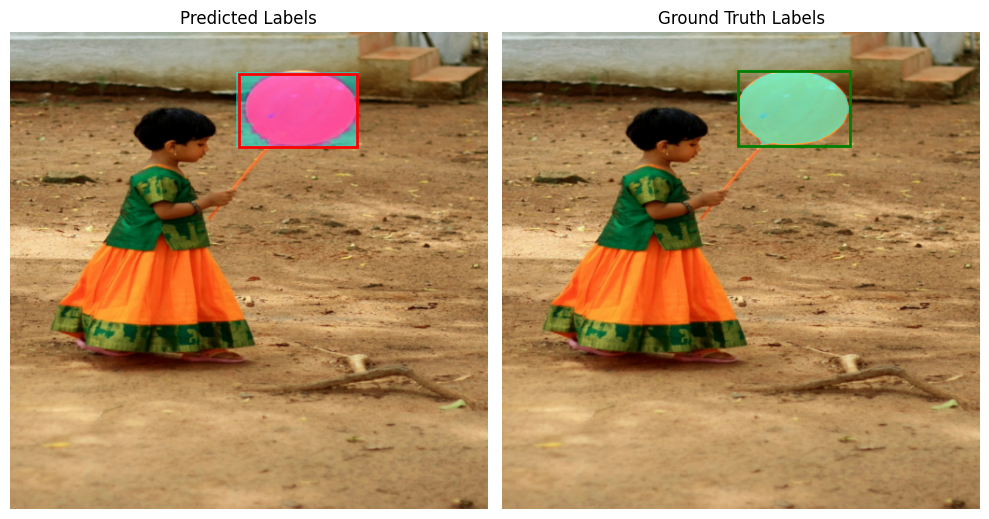

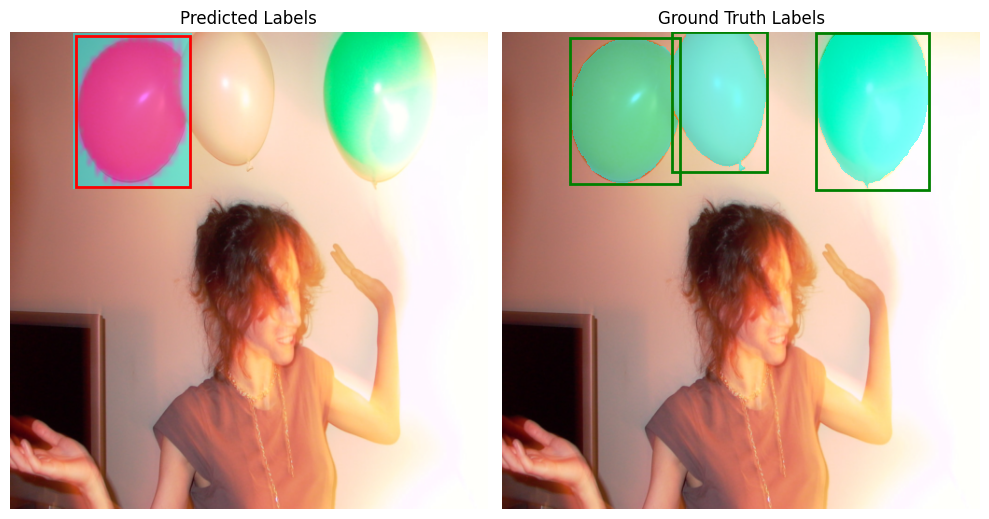

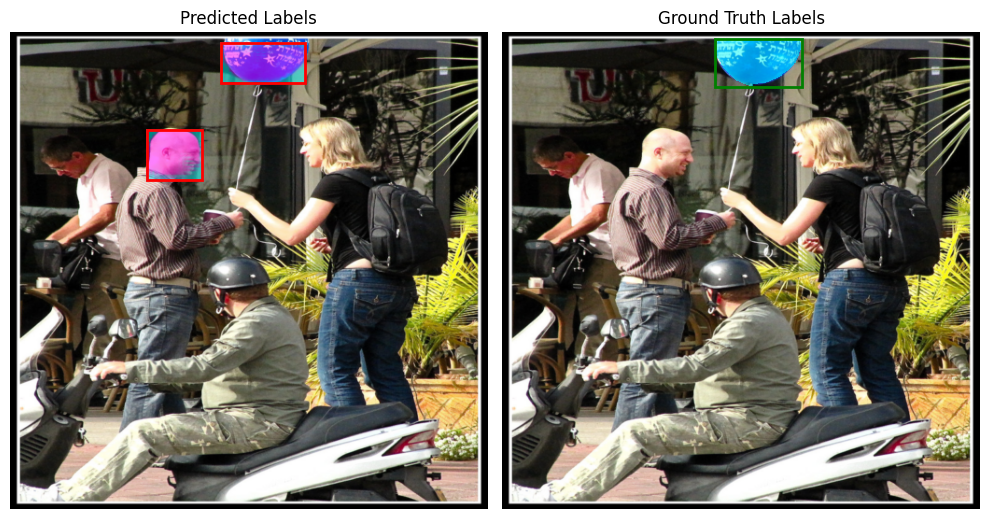

In [31]:
model.eval()

with torch.no_grad():
    for images, targets in val_data_loader:
        images = [image.to(device) for image in images]
        predictions = model(images)

        # For each image in the batch
        for idx in range(len(images)):
            image = images[idx]
            target = targets[idx]

            predicted_masks = predictions[idx]['masks']
            predicted_boxes = predictions[idx]['boxes']
            predicted_scores = predictions[idx]['scores']

            gt_masks = target['masks']
            gt_boxes = target['boxes']

            # Visualize the image with predicted and ground truth labels side by side
            visualize_image_with_masks_side_by_side(image, predicted_masks, predicted_boxes, predicted_scores, gt_masks, gt_boxes, threshold=pred_threshold)

## 5.4 Hyperparameter Tuning
<!--
- Fine-tune the model using techniques like Grid Search or Random Search.
- Evaluate the impact of different hyperparameters.
-->

In [32]:
tuner_config = {
    'lr_min': lr_min,
    'lr_max': lr_max,
    'weight_decay_min': weight_decay_min,
    'weight_decay_max': weight_decay_max,
    'optimizers': optimizers,
    'epochs_min': epochs_min,
    'epochs_max': epochs_max,
    'num_classes': num_classes
}

In [33]:
study = optuna.create_study(direction=direction, study_name=study_name, storage=storage, load_if_exists=True)

[I 2024-10-29 23:29:17,254] Using an existing study with name 'mask_rcnn_hyperparameter_tuning' instead of creating a new one.


In [34]:
optuna_process = subprocess.Popen(
    ["optuna-dashboard", "-q", "--port", str(optuna_port), storage],
    stdout=subprocess.DEVNULL,  # Suppresses standard output
    stderr=subprocess.DEVNULL   # Suppresses standard error (warnings and logs)
)

time.sleep(5)
print(f"Optuna Dashboard is running. Access it via http://localhost:{optuna_port}/")

Optuna Dashboard is running. Access it via http://localhost:8080/


In [ ]:
study.optimize(lambda trial: objective(trial, train_data_loader=train_data_loader, val_data_loader=val_data_loader, device=device, config=tuner_config, writer=writer), n_trials=n_trials, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-10-29 23:34:09,318] Trial 14 finished with value: 0.9931205287575722 and parameters: {'lr': 0.0006649943326925905, 'weight_decay': 0.00034865478799970856, 'optimizer': 'Adam', 'num_epochs': 96}. Best is trial 8 with value: 0.8090457394719124.


In [ ]:
print("Best hyperparameters: ", study.best_params)

## 5.5 Model Testing
<!--
- Evaluate the final model on the test dataset.
- Ensure that the model generalizes well to unseen data.
-->

## 5.6 Model Interpretation (Optional)
<!--
- Interpret the model results (e.g., feature importance, SHAP values).
- Discuss the strengths and limitations of the model.
-->

---

# 6. Predictions


## 6.1 Make Predictions
<!--
- Use the trained model to make predictions on new/unseen data.
-->

In [37]:
# writer.add_scalars('Loss - best params', {'train': avg_train_loss, 'val': avg_val_loss}, epoch)
# writer.flush()

## 6.2 Save Model and Results
<!--
- Save the trained model to disk for future use.
- Export prediction results for further analysis.
-->

In [ ]:
# Save the model
model_path = "../models/mask_rcnn_balloon.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

## 6.3 Cleanup

In [ ]:
writer.close()

tb_process.terminate()
tb_process.wait()
print("TensorBoard process terminated.")

optuna_process.terminate()
optuna_process.wait()
print("Optuna Dashboard process terminated.")

---

# 7. Documentation and Reporting

## 7.1 Summary of Findings
<!--
- Summarize the results and findings of the analysis.
-->

## 7.2 Next Steps
<!--
- Suggest further improvements, alternative models, or future work.
-->

## 7.3 References
<!--
- Cite any resources, papers, or documentation used.
-->